# Interpolating the Libor rate

<a href="https://juanfonsecasolis.github.io/">Juan M. Fonseca-Solís</a> · March 2015 (updated on December 2024) · 7 min read

---

## Summary

In this _ipython notebook_ we'll use data from daily reference rates, such as the London interbank interest rate (LIBOR), offered monthly by the Central Bank of Costa Rica (BCCR), to explain a linear and trigonometric interpolation techniques.

# History

In June 2012, when resolving a legal dispute, the Commodity Futures Negotiation Commission of the United States (CFTC) discovered a series of irregularities in the management of the LIBOR by the British multinational bank Barclays. The Financial Times newspaper later confirmed the manipulation of this rate since 1991, which caused an international scandal, since the LIBOR is used as a reference to determine the interest rate of the loans in foreign currency all over the world [4,5].

![](img/libor-scandal-headlines-the-financial-times-newspaper-london-august-CTX670.jpg)

As a result, millionaire fines were imposed on the British bank and an investigation was performed to find more reliable interest rates, including the first-rate, a rate managed by US banks that is based on real transactions and not on opinion polls like the LIBOR. Year 2022 was the end of life for the LIBOR [4,5].

![](img/article-2172377-140736A7000005DC-647_634x422.jpg)

The LIBOR, along with other daily reference rates, is published once a day with a scale of four maturity levels (the time until the loan will be charged):
* 1 month
* 3 months
* 6 months
* 12 months

Because only four values are published, banks usually require to linearly interpolate other maturity levels. For example, if interest rates of 1 and 3 months LIBOR are $4.3313$% and $4.3944$%, respectively, the maturity level at $1.5$ months is $4.3155\%$, calculated as follows [6]:

$$
y_n = \frac{y_1-y_0}{x_1-x_0} (x_n-x_0) + y_0,
$$

where $(x_0,y_0)=(30$ days$, 4.3313\%)$, and $(x_1,y_1)=(90$ days$, 4.3944\%)$. In the sections below we explain how linear interpolation works and how we can use other types of interpolation, like a trigonometric one.

(array([18687.25, 18748.25, 18809.25, 18871.25, 18932.25, 18993.25,
        19052.25, 19113.25, 19174.25]),
 [Text(18687.25, 0, '2021-03'),
  Text(18748.25, 0, '2021-05'),
  Text(18809.25, 0, '2021-07'),
  Text(18871.25, 0, '2021-09'),
  Text(18932.25, 0, '2021-11'),
  Text(18993.25, 0, '2022-01'),
  Text(19052.25, 0, '2022-03'),
  Text(19113.25, 0, '2022-05'),
  Text(19174.25, 0, '2022-07')])

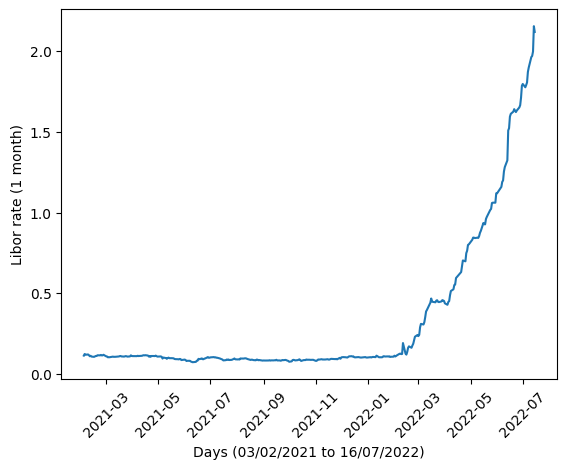

In [59]:
%matplotlib inline

import matplotlib.pylab as plt
from zeep import Client # SOAP client
import xml.etree.ElementTree as ET # read XMLs
import datetime
import numpy
import os
import dateutil.parser

client = Client('https://gee.bccr.fi.cr/Indicadores/Suscripciones/WS/wsindicadoreseconomicos.asmx?WSDL')

# Libor rates (https://gee.bccr.fi.cr/indicadoreseconomicos/Documentos/DocumentosMetodologiasNotasTecnicas/Webservices_de_indicadores_economicos.pdf)
liborRateMonthTypes = {
    '1': 349,
    '3': 349,
    '6': 349,
    '12': 349,
}

# find the Libor rate since a date in the past
fechaInicio = '03/02/2021'
fechaFinal = '16/07/2022'

dicc = client.service.ObtenerIndicadoresEconomicosXML(
	Indicador=liborRateMonthTypes['1'], 
	FechaInicio=fechaInicio,
	FechaFinal=fechaFinal,
    Nombre = 'Juan M. Fonseca',
	SubNiveles = 'N',
    CorreoElectronico = 'juanma2268@gmail.com',
    Token = os.environ['BCCR_TOKEN']
)

# extract the XML that comes embedded in the dictionary data structure
raiz = ET.fromstring(dicc)

# build the signal
x = []
y = []
for hijo in raiz:
    if 2<len(hijo):    # weekends have no rate
        x.append(dateutil.parser.isoparse(hijo[1].text))
        y.append(float(hijo[2].text))
    
# plot
N = len(x)
plt.plot(x, y)
plt.xlabel('Days (%s to %s)' % (fechaInicio, fechaFinal))
plt.ylabel('Libor rate (1 month)')
plt.xticks(rotation = 45)

## Sampling of a signal

Even it is not continuous, the LIBOR daily rate $z$ constitutes a discrete signal, that by choosing a sampling period $T$ of one day, can be expressed mathematically as follows [2,3]:
$$
\tilde{z}[i] = z(iT) \quad i \in \mathbb{Z},
$$

where $\tilde{z}[i]$ and $z(t)$ are the discrete and continuous version of the signal, respectively. This means that the continuous signal can be converted into a discrete signal by reading its values in the instants $iT$. Using a notation of ordered pairs this can also be expressed as follows:

$$
\{(x_i,\tilde{z}_i)\}_{i=-\infty}^{\infty},
$$

where $x_{i+1}-x_i = T$ seconds. In both cases it is necessary to ensure that the $T_{\max} \ge 2T$ relationship is fulfilled (where $T_\max$ is the largest component of the signal). This relationship is summarized in what is known as the [Nyquist theorem](https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem). If this theorem is not followed the reconstructed signal could be corrupted with [aliasing](https://en.wikipedia.org/wiki/Aliasing). 

**Note:** although the Nyquist theorem is an important topic on audio and video processing applications, we will ignore it here for practical purposes and because we know that the daily rate signal is bandlimited (that is, there are no variations between days).

## Lineal interpolation

The interpolation of a discrete signal is achieved by [convolving](https://en.wikipedia.org/wiki/Convolution) an interpolation function $I(t)$ &ndash;also called _interpolation kernel_&ndash; with each sample available, then a sum of all convolutions is performed to obtain a continuous function [3]: 

$$
    z(t) =  \sum_{i=-\infty}^{\infty}{\tilde{z}[i]I\big(\frac{t-iT}{T}\big)} 
$$

This is easier to understand with a example signal:

<StemContainer object of 3 artists>

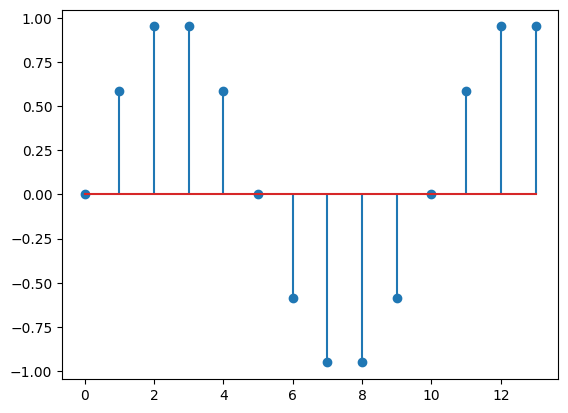

In [49]:
import numpy as np
zt=np.sin(2*np.pi*10/100*np.arange(0,N))
#zt = [0, 0, 2.64286, 2.68486, 2.70457, 2.75643, 2.77314, 0, 0, 2.78343, 2.81771, 2.93914, 2.99343, 3.01386]
pylab.stem(zt)

First, the previous signal is resampled at a higher sampling rate by adding zeros in the middle of the samples:

<StemContainer object of 3 artists>

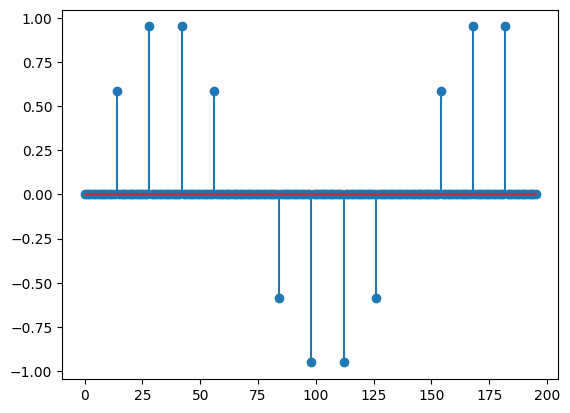

In [50]:
from scipy import signal
N=len(zt)
M=N*14
ztt = [0.0]*M
ztt[::N] = zt
pylab.stem(ztt)

Then we perform a convolution of each sample with a triangular kernel:

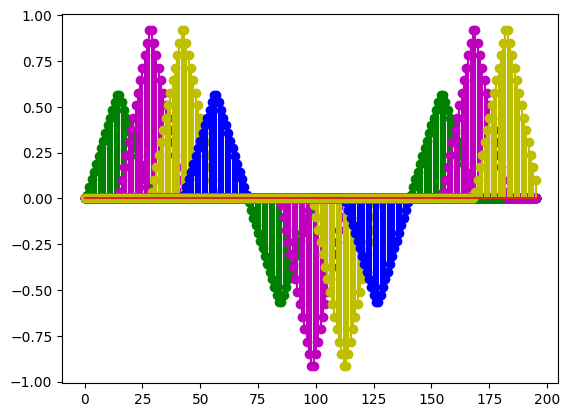

In [51]:
kernel=signal.windows.triang(2*N)
z = np.zeros(M)
colors = ['r', 'g', 'm', 'y', 'b']
for i in range(1,N):
    zeros = np.zeros(M)
    zeros[i*N]=zt[i] 
    z += np.convolve(zeros,kernel,'same')
    pylab.stem(np.convolve(zeros,kernel,'same'),colors[i%len(colors)],markerfmt='%so'%colors[i%len(colors)])

And the result is a signal that "connects" the points:

<StemContainer object of 3 artists>

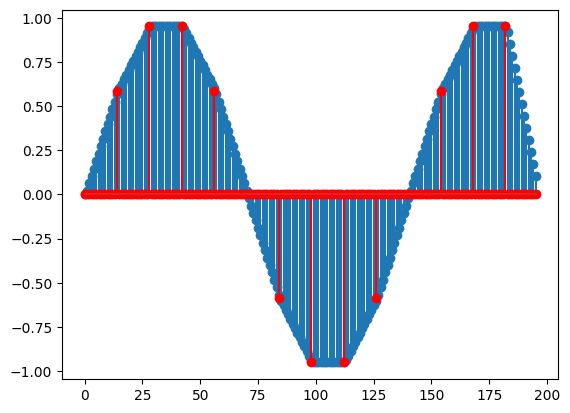

In [52]:
pylab.stem(z)
pylab.stem(ztt,'ro-')

Using an inverted-bell-non-triangular kernel &ndash; called _Hamming window_&ndash; we can obtain a smoother approximation, here is the formula of the kernel [7]:

$$
w[n] = 0.54 - 0.46 \cos \left( 2 \pi \frac{n}{N} \right), \qquad 0 \leq n \leq N.
$$

And below the result of convoluting each point with this new equation, along the sum:

<StemContainer object of 3 artists>

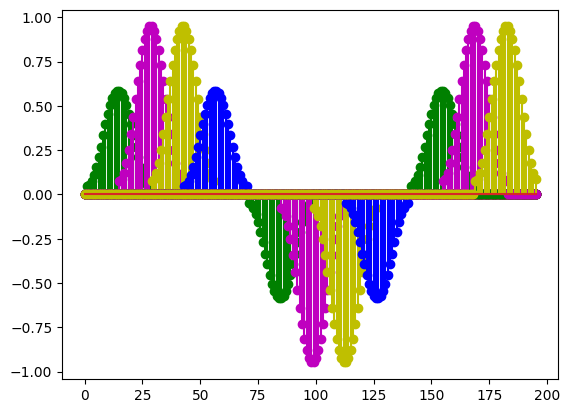

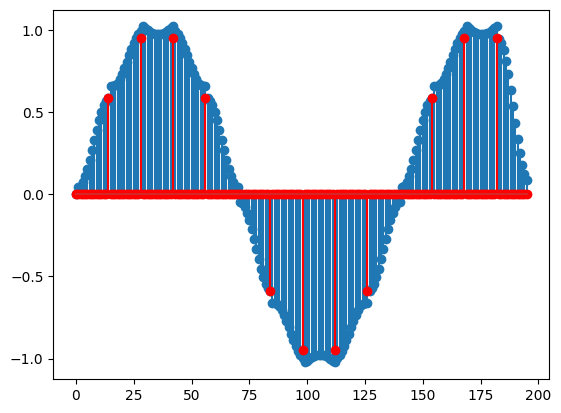

In [53]:
kernel=signal.windows.hamming(2*N)
z = np.zeros(M)
colors = ['r', 'g', 'm', 'y', 'b']

pylab.figure()
for i in range(1,N):
    zeros = np.zeros(M)
    zeros[i*N]=zt[i] 
    z += np.convolve(zeros,kernel,'same')
    pylab.stem(np.convolve(zeros,kernel,'same'),colors[i%len(colors)],markerfmt='%so'%colors[i%len(colors)])

pylab.figure()
pylab.stem(z)
pylab.stem(ztt,'ro-')

Interpolation could be done even ignoring the sampling rate, but it is observed that some information, like periodicity, has been lost.

## References:

1. Banco Central de Costa Rica. **Tasa libor 1 mes**. URL: https://gee.bccr.fi.cr/indicadoreseconomicos/Cuadros/frmVerCatCuadro.aspx?idioma=1&CodCuadro=%20334 (last consulted on 04/11/15).

2. LCAV, Ecolé Polytechnique Federale de Lausanne. **Safecast : Band-limited interpolation of radiation measurements in Fukushima** URL: https://nbviewer.jupyter.org/github/LCAV/SignalsOfTheDay/blob/master/Safecast/Safecast.ipynb.

3. P. Prandoni, M. Vertterli. **Signal processing for communications.** EPFL press 2008.

4. Wikipedia contributors. (2019, August 1). Libor scandal. In Wikipedia, The Free Encyclopedia. Retrieved 23:50, August 15, 2019, from https://en.wikipedia.org/w/index.php?title=Libor_scandal&oldid=908807968.

5. Miguel Elizondo. El LIBOR dejará de existir en el 2021. La República.net, Impacto legal. Monday, July 31-th, 2017. URL: https://www.larepublica.net/noticia/el-libor-dejara-de-existir-en-el-2021.

6. Linear interpolation example. International Swaps and Derivatives Association. URL: https://www.isda.org/a/7KiDE/linear-interpolation-example-1-10.pdf.

7. Scipy. Hamming. URL: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.windows.hamming.html (last consulted on 12/31/24).

## Notes

1. In these cases, we talk about "innovation rate" (FIR), rather than sampling frequency.
2. It can be proven that the [least squares method](https://es.wikipedia.org/wiki/M%C3%ADnimos_cuadrados) works using the standard approximation theorem.
3. An excellent resource on how to use the services of the BCCR can also be found at [Tico](https://tecnitico.wordpress.com/2010/11/11/webservice-del-banco-central-de-costa-rica-y-ruby).
4. The images were taken from [here](https://i.dailymail.co.uk/i/pix/2012/07/12/article-2172377-140736A7000005DC-647_634x422.jpg) and [here](https://c8.alamy.com/comp/CTX670/libor-scandal-headlines-the-financial-times-newspaper-london-august-CTX670.jpg)

---
<a rel="license" href="http://creativecommons.org/licenses/by-nd/4.0/"><img alt="licencia Creative Commons" style="border-width:0" src="img/80x15_by-nd.png" /></a><p style="text-align: center;"> This work is under a <a rel="license" href="http://creativecommons.org/licenses/by-nd/4.0/">Creative Commons Atribución 4.0 Internacional license</a>. The website <a href="https://juanfonsecasolis.github.io/">juanfonsecasolis.github.io</a> It is a Costa Rican blog dedicated to independent research on issues related to digital signal processing. To reuse this article and cite the source you can use Bibtex:</p>
```
@online{Fonseca2018,
  author = {Juan M. Fonseca-Solís},
  title = { Limited band interpolation for daily reference rates},
  year = 2015,
  url = {https://juanfonsecasolis.github.io/blog/JFonseca.interpolacionBL.html},
  urldate = {}
}
```

<!-- DISQUIS -->

<div id="disqus_thread"></div>
<script>

/**
*  RECOMMENDED CONFIGURATION VARIABLES: EDIT AND UNCOMMENT THE SECTION BELOW TO INSERT DYNAMIC VALUES FROM YOUR PLATFORM OR CMS.
*  LEARN WHY DEFINING THESE VARIABLES IS IMPORTANT: https://disqus.com/admin/universalcode/#configuration-variables
*/
var disqus_config = function () {
this.page.url = 'https://juanfonsecasolis.github.io/blog/JFonseca.interpolacionBL.html';  // Replace PAGE_URL with your page's canonical URL variable
this.page.identifier = 1; // Replace PAGE_IDENTIFIER with your page's unique identifier variable
};

(function() { // DON'T EDIT BELOW THIS LINE
var d = document, s = d.createElement('script');
s.src = 'https://https-juanfonsecasolis-github-io.disqus.com/embed.js';
s.setAttribute('data-timestamp', +new Date());
(d.head || d.body).appendChild(s);
})();
</script>
<noscript>Please enable JavaScript to view the <a href="https://disqus.com/?ref_noscript">comments powered by Disqus.</a></noscript>
<script id="dsq-count-scr" src="https://https-juanfonsecasolis-github-io.disqus.com/count.js" async></script>